# Automating Pipeline with AutoML 

AutoML approach deployed previously can be integrated with orchestration pipelines (in our case Kubeflow). This orchestration pipeline can be used to orchestrate the process of custom training the custom model with AutoML and deploy it automatically at the endpoint for ML prediction and explanations. In that sense, it automates the code based approach of the previous AutoML model development. 

## Setting Up



In [1]:
REGION = 'us-central1'
PROJECT_ID='mlopstqc'
DATANAME = 'leaktest'
IDENTIFIER = '3'

# Resources
DEPLOY_COMPUTE = 'n1-standard-2'

# Model Training
VAR_TARGET = 'TestPressureMbar'
VAR_OMIT = 'transaction_id' 

In [2]:
from google.cloud import aiplatform
from datetime import datetime
import kfp

from google_cloud_pipeline_components import aiplatform as gcc_aip

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

In [3]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

In [4]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{DATANAME}/models/{IDENTIFIER}"
DIR = f"temp/{IDENTIFIER}"

In [5]:
#Giving permissions to the user : objectAdmin
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'969346734638-compute@developer.gserviceaccount.com'

In [6]:
!rm -rf {DIR}
!mkdir -p {DIR}

## Defining the Pipeline

Pipeline deals with creating the dataset by sourcing from data warehouse (Big Query), formulating a training model and  setting the running conditions of the training model. The trained model is then deployed on a created endpoint.

In [23]:
@kfp.dsl.pipeline(name = f'kfp-{IDENTIFIER}-{DATANAME}-{TIMESTAMP}', pipeline_root = URI+'/'+str(TIMESTAMP)+'/kfp/')
#defining the piepline
def pipeline(
    project: str = PROJECT_ID,
    dataname: str = DATANAME,
    display_name: str = f'{IDENTIFIER}_{DATANAME}_{TIMESTAMP}',
    deploy_machine: str = DEPLOY_COMPUTE,
    bq_source: str = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    var_target: str = VAR_TARGET,
    var_omit: str = VAR_OMIT,
    label: str = IDENTIFIER
):
    
    # loading the sourced data from data warehouse and creating a dataset
    dataset = gcc_aip.TabularDatasetCreateOp(
        project = project,
        display_name = display_name,
        bq_source = bq_source,
        # labels = {'identifier':f'{label}'}
    )
    
    # getting feature names
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = PROJECT_ID)
    query = f"SELECT * FROM {DATANAME}.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{DATANAME}_prepped'"
    schema = bigquery.query(query).to_dataframe()
    OMIT = VAR_OMIT.split() + [VAR_TARGET, 'splits']
    features = schema[~schema.column_name.isin(OMIT)].column_name.tolist()
    features = dict.fromkeys(features, 'auto')
    
    # training the model
    model = gcc_aip.AutoMLTabularTrainingJobRunOp(
        project = project,
        display_name = display_name,
        optimization_prediction_type = "classification",
        optimization_objective = "minimize-log-loss",
        budget_milli_node_hours = 500,
        disable_early_stopping=False,
        column_specs = features,
        dataset = dataset.outputs['dataset'],
        target_column = var_target,
        predefined_split_column_name = 'splits',
        # labels = {'identifier':f'{label}'}
    )
    
    # Creating the endpoint
    endpoint = gcc_aip.EndpointCreateOp(
        project = project,
        display_name = display_name,
        # labels = {'identifier':f'{label}'}
    )
    
    # Endpoint: Deployment of Model
    deployment = gcc_aip.ModelDeployOp(
        model = model.outputs["model"],
        endpoint = endpoint.outputs["endpoint"],
        dedicated_resources_min_replica_count = 1,
        dedicated_resources_max_replica_count = 1,
        traffic_split = {"0": 100},
        dedicated_resources_machine_type= deploy_machine
    )


## Compiling the defined pipeline

In [24]:
kfp.v2.compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path= f"{DIR}/{IDENTIFIER}.json"

)

/opt/conda/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


In [25]:
##moving the pipleine to the storage


!gsutil cp {DIR}/{IDENTIFIER}.json {URI}/{TIMESTAMP}/kfp/



E0330 12:44:51.862415143   27497 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying file://temp/3/3.json [Content-Type=application/json]...
/ [1 files][ 22.9 KiB/ 22.9 KiB]                                                
Operation completed over 1 objects/22.9 KiB.                                     


## Running the AI pipeline Job



In [26]:
pipeline = aiplatform.PipelineJob(
    display_name = f'{IDENTIFIER}_{DATANAME}_{TIMESTAMP}',
    template_path = f"{URI}/{TIMESTAMP}/kfp/{IDENTIFIER}.json",
    pipeline_root = f"{URI}/{TIMESTAMP}/kfp/",
    labels = {'identifier':f'{IDENTIFIER}'}
)

In [27]:
response = pipeline.run(service_account = SERVICE_ACCOUNT)

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/969346734638/locations/us-central1/pipelineJobs/kfp-3-leaktest-20220330110904-20220330124456
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/969346734638/locations/us-central1/pipelineJobs/kfp-3-leaktest-20220330110904-20220330124456')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/kfp-3-leaktest-20220330110904-20220330124456?project=969346734638
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/969346734638/locations/us-central1/pipelineJobs/kfp-3-leaktest-20220330110904-20220330124456 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projec

In [28]:
aiplatform.get_pipeline_df(pipeline = f'kfp-{IDENTIFIER}-{DATANAME}-{TIMESTAMP}')

,pipeline_name,run_name,param.input:bq_source,param.input:display_name,param.input:var_target,param.input:dataname,param.input:deploy_machine,param.input:project,param.input:var_omit,param.input:label
0,kfp-3-leaktest-20220330110904,kfp-3-leaktest-20220330110904-20220330124456,bq://mlopstqc.leaktest.leaktest_prepped,3_leaktest_20220330110904,TestPressureMbar,leaktest,n1-standard-2,mlopstqc,transaction_id,3
1,kfp-3-leaktest-20220330110904,kfp-3-leaktest-20220330110904-20220330123351,bq://mlopstqc.leaktest.leaktest_prepped,3_leaktest_20220330110904,TestPressureMbar,leaktest,n1-standard-2,mlopstqc,transaction_id,3
2,kfp-3-leaktest-20220330110904,kfp-3-leaktest-20220330110904-20220330122311,bq://mlopstqc.leaktest.leaktest_prepped,3_leaktest_20220330110904,TestPressureMbar,leaktest,n1-standard-2,mlopstqc,transaction_id,3
3,kfp-3-leaktest-20220330110904,kfp-3-leaktest-20220330110904-20220330113758,bq://mlopstqc.leaktest.leaktest_prepped,3_leaktest_20220330110904,TestPressureMbar,leaktest,n1-standard-2,mlopstqc,transaction_id,3


## Evaluation

In [35]:
model = aiplatform.Model.list(filter=f'display_name={IDENTIFIER}_{DATANAME}_{TIMESTAMP}')

In [37]:
model[0].resource_name

'projects/969346734638/locations/us-central1/models/1070330589174824960'

In [33]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

In [38]:
evaluations = model_client.list_model_evaluations(parent = model[0].resource_name)
evals = iter(evaluations)
eval_id = next(evals).name
geteval = model_client.get_model_evaluation(name = eval_id)

In [39]:
geteval.metrics['auPrc']

0.76063657

In [40]:
for i in range(len(geteval.metrics['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', geteval.metrics['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', geteval.metrics['confusionMatrix']['rows'][i])

True Label =  15500  has Predicted labels =  [2792.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [41]:
slices = model_client.list_model_evaluation_slices(parent = eval_id)

In [42]:
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  43800 has auPrc =  0.00029904305


KeyError: 'auPrc'

## Preparing Prediction record

In [43]:
pred = bigquery.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()

In [44]:
pred.head(4)


,TestVolumeLitre,AlarmDiffPressure,TestPressureMbar,transaction_id,splits
0,0.2,500,12800,68cfe17b-33f6-4240-9254-d77514feb083,TEST
1,10.0,320,12800,e6cc26be-a050-4c91-99cf-52c2dcea0924,TEST
2,0.1,320,12800,b5e82b71-f62a-400a-9cf1-f551b2b57bf9,TEST
3,0.1,320,12800,d2f9cc2b-4aed-4734-a723-17b44020021b,TEST


In [45]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]

In [46]:
newob['AlarmDiffPressure'] = str(newob['AlarmDiffPressure'])

In [47]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

In [48]:
instances

[struct_value {
   fields {
     key: "AlarmDiffPressure"
     value {
       string_value: "500"
     }
   }
   fields {
     key: "TestVolumeLitre"
     value {
       number_value: 0.2
     }
   }
 }]

## Getting Prediction

In [49]:
aiplatform.Endpoint.list(filter=f'display_name={IDENTIFIER}_{DATANAME}_{TIMESTAMP}')

 resource name: projects/969346734638/locations/us-central1/endpoints/6028182450444697600]

In [50]:
endpoint = aiplatform.Endpoint.list(filter=f'display_name={IDENTIFIER}_{DATANAME}_{TIMESTAMP}')[0]
endpoint.display_name

'3_leaktest_20220330110904'

In [52]:
prediction = endpoint.predict(instances=instances, parameters=parameters)
prediction


Prediction(predictions=[{'classes': ['15500', '19800', '16400', '18000', '13600', '13400', '13200', '24000', '23600', '20800', '18200', '17800', '17600', '17200', '16800', '16000', '12800', '12000', '10200', '24400', '21200', '21000', '20600', '20000', '18800', '15000', '14200', '11200', '11000', '23400', '22200', '16600', '15800', '15600', '14800', '13000', '12600', '10800', '29800', '27200', '22800', '22600', '22400', '22000', '21800', '21400', '19200', '18400', '17000', '15400', '14400', '12200', '11400', '10600', '28800', '25200', '21600', '20200', '19600', '19000', '18600', '26600', '26200', '25000', '20400', '19400', '17400', '15200', '14000', '11800', '10000', '29400', '28000', '27800', '25800', '24600', '23200', '23000', '12400', '10400', '28400', '27000', '26800', '14600', '13800', '29200', '25400', '23800', '29000', '27400', '26000', '11600', '24800', '24200', '29600', '28200', '27600', '25600', '28600', '16200', '26400', '30400', '30200', '30000', '30600', '31600', '31800', 

In [53]:
prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'15500'

## REST Prediction

In [54]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

In [55]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

E0330 15:34:42.148594155   27497 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


{
  "predictions": [
    {
      "scores": [
        0.880673885345459,
        0.0011142177972942591,
        0.001110757351852953,
        0.001103820162825286,
        0.001092542195692658,
        0.001157773076556623,
        0.001074824598617852,
        0.0010460061021149161,
        0.0010688806651160121,
        0.001095264917239547,
        0.0011049079475924371,
        0.001097570289857686,
        0.0011049830354750161,
        0.001113949809223413,
        0.001102334470488131,
        0.001065351767465472,
        0.001090013072825968,
        0.0010879569454118609,
        0.001064450945705175,
        0.001038573565892875,
        0.0010850913822650909,
        0.0010729158530011771,
        0.0010828491067513819,
        0.001086740172468126,
        0.001092585502192378,
        0.001125033828429878,
        0.0010509793646633629,
        0.0010600809473544359,
        0.00105178530793637,
        0.001073542865924537,
        0.001074470579624176,
        0.00106437

## Terminal

In [56]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json


E0330 15:35:26.622515507   27497 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['15500', '19800', '16400', '18000', '13600', '13400', '13200', '24000', '23600', '20800', '18200', '17800', '17600', '17200', '16800', '16000', '12800', '12000', '10200', '24400', '21200', '21000', '20600', '20000', '18800', '15000', '14200', '11200', '11000', '23400', '22200', '16600', '15800', '15600', '14800', '13000', '12600', '10800', '29800', '27200', '22800', '22600', '22400', '22000', '21800', '21400', '19200', '18400', '17000', '15400', '14400', '12200', '11400', '10600', '28800', '25200', '21600', '20200', '19600', '19000', '18600', '26600', '26200', '25000', '20400', '19400', '17400', '15200', '14000', '11800', '10000', '29400', '28000', '27800', '25800', '24600', '23200', '23000', '12400', '10400', '28400', '27000', '26800', '14600', '13800', '29200', '25400', '23800', '29000', '27400', '26000', '11600', '24800', '24200', '29600', '28200', '27600', '25600', '28600', '16200', '26400', '3

## Interpretation

In [57]:
explanation = endpoint.explain(instances=instances, parameters=parameters)


In [58]:
explanation.predictions

[{'scores': [0.880673885345459,
   0.001114217797294259,
   0.001110757351852953,
   0.001103820162825286,
   0.001092542195692658,
   0.001157773076556623,
   0.001074824598617852,
   0.001046006102114916,
   0.001068880665116012,
   0.001095264917239547,
   0.001104907947592437,
   0.001097570289857686,
   0.001104983035475016,
   0.001113949809223413,
   0.001102334470488131,
   0.001065351767465472,
   0.001090013072825968,
   0.001087956945411861,
   0.001064450945705175,
   0.001038573565892875,
   0.001085091382265091,
   0.001072915853001177,
   0.001082849106751382,
   0.001086740172468126,
   0.001092585502192378,
   0.001125033828429878,
   0.001050979364663363,
   0.001060080947354436,
   0.00105178530793637,
   0.001073542865924537,
   0.001074470579624176,
   0.001064372481778264,
   0.001063906121999025,
   0.001075372565537691,
   0.001109986333176494,
   0.001109241507947445,
   0.001115315477363765,
   0.001125257927924395,
   0.00103398400824517,
   0.001029261155053

In [59]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.7517624497413635
instance output 0.880673885345459
output_index [0]
output display value 15500
approximation error 0.005271374423934824


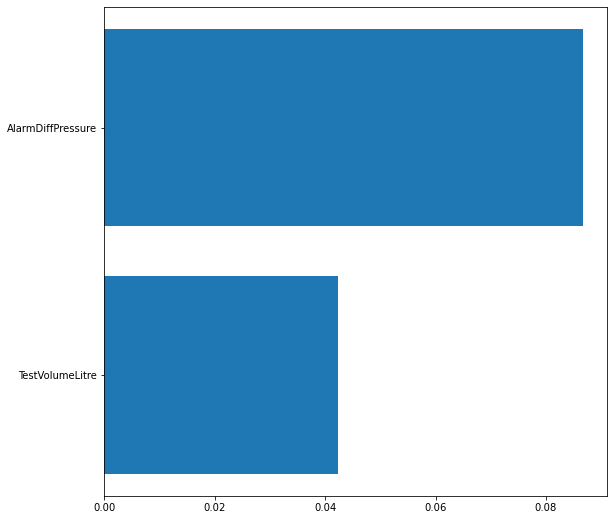

In [61]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

## Batch Prediction

End-to-End

In [ ]:
## reference to previous